In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Dropout
from tensorflow.keras.layers import LSTM
from matplotlib import pyplot






In [3]:
df_reviews_train = pd.read_csv('aclImdb/train/trainReviews.txt', sep='delimiter', names=['Review'], engine = 'python')
df_scores_train = pd.read_csv('aclImdb/train/IMDBValuesTrain.txt', sep='delimiter', names=['Score'], engine = 'python')

df_reviews_test = pd.read_csv('aclImdb/test/testReviews.txt', sep='delimiter', names=['Review'], engine = 'python')
df_scores_test = pd.read_csv('aclImdb/test/IMDBValuesTest.txt', sep='delimiter', names=['Score'], engine = 'python')

print(df_reviews_train)
print(df_scores_train)

                                                  Review
0      Story of a man who has unnatural feelings for ...
1      Airport '77 starts as a brand new luxury 747 p...
2      This film lacked something I couldn't put my f...
3      Sorry everyone,,, I know this is supposed to b...
4      When I was little my parents took me along to ...
...                                                  ...
24995  Seeing as the vote average was pretty low, and...
24996  The plot had some wretched, unbelievable twist...
24997  I am amazed at how this movie(and most others ...
24998  A Christmas Together actually came before my t...
24999  Working-class romantic drama from director Mar...

[25000 rows x 1 columns]
       Score
0          3
1          4
2          4
3          1
4          1
...      ...
24995      9
24996      8
24997     10
24998      8
24999      7

[25000 rows x 1 columns]


In [4]:
df_reviews_train['Review'] = df_reviews_train['Review'].str.lower()   # lowercase the Dataset
df_reviews_test['Review'] = df_reviews_test['Review'].str.lower()

df_reviews_train['Review'] = df_reviews_train['Review'].str.replace(r'[^\w\s]+', '')   # Remove Punctuation from Dataset
df_reviews_test['Review'] = df_reviews_test['Review'].str.replace(r'[^\w\s]+', '')

stop_words = set(stopwords.words('english'))
df_reviews_train['Review'] = df_reviews_train['Review'].apply(lambda review: [i for i in review.split() if i not in stop_words])   # Remove Stopwords
df_reviews_test['Review'] = df_reviews_test['Review'].apply(lambda review: [i for i in review.split() if i not in stop_words])   # Remove Stopwords


print(df_reviews_train)
print(df_reviews_test)

                                                  Review
0      [story, man, unnatural, feelings, pig, starts,...
1      [airport, 77, starts, brand, new, luxury, 747,...
2      [film, lacked, something, couldnt, put, finger...
3      [sorry, everyone, know, supposed, art, film, w...
4      [little, parents, took, along, theater, see, i...
...                                                  ...
24995  [seeing, vote, average, pretty, low, fact, cle...
24996  [plot, wretched, unbelievable, twists, however...
24997  [amazed, movieand, others, average, 5, stars, ...
24998  [christmas, together, actually, came, time, iv...
24999  [workingclass, romantic, drama, director, mart...

[25000 rows x 1 columns]
                                                  Review
0      [mr, costner, dragged, movie, far, longer, nec...
1      [example, majority, action, films, generic, bo...
2      [first, hate, moronic, rappers, couldnt, act, ...
3      [even, beatles, could, write, songs, everyone,...
4    

In [5]:
# Change Review Score to Binary Score
for score in df_scores_train['Score']:
    if score <= 5:
        df_scores_train = df_scores_train.replace(score, 0)
    else:
        df_scores_train = df_scores_train.replace(score, 1)

for score in df_scores_test['Score']:
    if score <= 5:
        df_scores_test = df_scores_test.replace(score, 0)
    else:
        df_scores_test = df_scores_test.replace(score, 1)
print (df_scores_train)
print (df_scores_test)

       Score
0          0
1          0
2          0
3          0
4          0
...      ...
24995      1
24996      1
24997      1
24998      1
24999      1

[25000 rows x 1 columns]
       Score
0          0
1          0
2          0
3          0
4          0
...      ...
24995      1
24996      1
24997      1
24998      1
24999      1

[25000 rows x 1 columns]


In [6]:
# Length of the longest review
review_length = []
for review in df_reviews_train['Review']:
    review_length.append(len(review))

max_review = int(np.ceil(np.mean(review_length)))


In [7]:
# Converts words into integers
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_reviews_train['Review'])
df_reviews_train['Review'] = tokenizer.texts_to_sequences(df_reviews_train['Review'])
df_reviews_test['Review'] = tokenizer.texts_to_sequences(df_reviews_test['Review'])

df_reviews_train = sequence.pad_sequences(df_reviews_train['Review'], maxlen = max_review, padding = 'post')
df_reviews_test = sequence.pad_sequences(df_reviews_test['Review'], maxlen = max_review, padding = 'post')

print(df_reviews_train)
print(df_reviews_test)



[[   11    49  7487 ...     0     0     0]
 [ 2899  1542  2069 ...  4362 13466  5454]
 [    3  3459    53 ...     0     0     0]
 ...
 [   71    14    19 ...   976   107  9625]
 [  845   192    66 ...     0     0     0]
 [13545   605   367 ...     0     0     0]]
[[  328 12069  3133 ...     0     0     0]
 [  250   115    10 ...     3    82  2743]
 [   20   667  4855 ...     0     0     0]
 ...
 [   57   228     2 ...  3584    49   202]
 [    2  4551  4047 ...     0     0     0]
 [   99    33    11 ...     0     0     0]]


In [8]:
# Model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, 128, input_length = max_review))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(50, activation = "relu"))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

print(model.summary())




Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 125, 128)          15592960  
_________________________________________________________________
lstm (LSTM)                  (None, 64)                49408     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 5

In [9]:
# Training
history = model.fit(df_reviews_train, df_scores_train,
          batch_size = 128, epochs = 2, verbose = 2, validation_data = (df_reviews_test, df_scores_test))

Epoch 1/2
196/196 - 44s - loss: 0.6052 - accuracy: 0.6384 - val_loss: 0.4214 - val_accuracy: 0.8284
Epoch 2/2
196/196 - 41s - loss: 0.2801 - accuracy: 0.9018 - val_loss: 0.3515 - val_accuracy: 0.8624


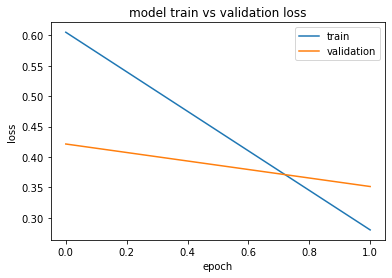

In [10]:
# Analyzing Fit
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [11]:
# Testing
results = model.evaluate(df_reviews_test, df_scores_test, batch_size=128)
print(results)

196/196 [==============================] - 5s 27ms/step - loss: 0.3515 - accuracy: 0.8624
[0.35146602988243103, 0.8623600006103516]
